### General Comments about the data
##### Project Goal and Details

The data used in this project is retrieved from Berkeleyearth.org. 
The csv dataset imported into this project is prepared using a SQL.
Generally speaking, the temperatures explored in this project are in 
Celsius and correslong to anomalies relative to the Jan 1951 - Dec 1980 averages. 
The uncertainties correspond to the 95% confidence interval of statistical and
spatial undersampling effects. 

#### Project Roadmap:
1. Fetch data from Berkley website using Python.
2. Treat the data using PostgreSQL and a list of SQL queries creating a single csv dataset
3. Explore the data mined dataset using different visualization and statistical techniques
4. Forecast temperature time series using statistical SARIMA model
5. Predict the earth's temperature anomaly increasse in 2100

#### Dataset Description:
1. There are 5 types of temperature sub-datasets: 
    * **TAVG**: Average monthly and annual estimated land-surface temperature and its uncertainty (95% confidence)
    * **TMAX**: Maximum monthly and annual estimated land-surface temperature and its uncertainty (95% confidence)
    * **TMIN**: Minimum monthly and annual estimated land-surface temperature and its uncertainty (95% confidence)
    * **TAIR**: Global land and ocean average temperature using air temperature approximation for sea surface and its uncertainty (95% confidence)
    * **TWAT**: Global land and ocean average temperature using water temperature approximation for sea surface and its uncertainty (95% confidence)
    <br>
    <br>
2. The index of the dataset is the datetime of the measurement expressed in the following format "YYYY-MM-DD"
3. Each data category (avg, max, min, air, water) has 4 columns corresponding to hte Monthly and Yearly temperature annomalies and their respective uncertainties within the 95% confidence range

In [6]:
import pandas as pd
import numpy as np
import os

import sys 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import datetime as dt

import pmdarima as pm # Auto-Arima package >- 2,0,0

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import joblib # save arima models into a file

try:
    del sys.modules['sql_data_processing']
except:
    print("Importing module/class \"sql_data_processing\" of the first time")
finally:
    from sql_data_processing import *

try:
    del sys.modules['download_data_files']
except:
    print("Importing module/class \"download_data_files\" of the first time")
finally:
    from download_data_files import download

# Library where to save the figures:
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "Climate_Change"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images" + '_' + PROJECT_NAME)
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "Models" + '_' + PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok=True) # exist_ok avoid OSError error if directory exists already
os.makedirs(MODELS_PATH, exist_ok=True) # exist_ok avoid OSError error if directory exists already

def save_fig(figure_id, fig_extension="png", resolution=300):
    PATH_FIGURES = os.path.join(IMAGES_PATH, figure_id + "." + fig_extension)
    print("Saving figure:\"", figure_id, "\"")
    plt.savefig(PATH_FIGURES, format=fig_extension, dpi=resolution)

### Downloading Raw data from Berkeley-Earth.org

In [ ]:
URL1 = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Land_and_Ocean_complete.txt'
URL2 = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TAVG_complete.txt'
URL3 = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TMAX_complete.txt'
URL4 = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TMIN_complete.txt'
ALL_URLs = [URL1, URL2, URL3, URL4]
for url in ALL_URLs:
    download_file_instance = download(url)
    if url == URL1:
        download_file_instance.download_data_to_two_files()
    else:
        download_file_instance.download_data_to_file()

### Data Minining using SQL

In [ ]:
database="main_data_base"
host="localhost"
user="atsoc"
port="5435"
file_name_sql_1 = "SQL_Queries/Query 1 - Data Import.sql"
file_name_sql_2 = "SQL_Queries/Query 2 - Data Mining.sql"
file_name_sql_3 = "SQL_Queries/Query 3 - Data Export.sql"

sql_data_preparation = data_preparation(database, host, user, port)
try:
    sql_data_preparation.execute_sql_query(file_name_sql_1)
    sql_data_preparation.execute_sql_query(file_name_sql_2)
    sql_data_preparation.execute_sql_query(file_name_sql_3)
except psycopg2.errors.BadCopyFileFormat:
    print ('psycopg2.errors.BadCopyFileFormat')
    print('Probably, you already imported and transformed data')
    print('Check the SQL data tables')

In [7]:
raw_imported_data = pd.read_csv('Data_Prepared/Global_Temperatures_Data.csv')

In [8]:
new_columns_order = ["dt"] + raw_imported_data.columns[:4].to_list() + raw_imported_data.columns[5:].to_list()
new_columns_order, len(new_columns_order), raw_imported_data.columns.size

(['dt',
  'Anomaly Monthly TAVG',
  'Unc. Monthly TAVG',
  'Anomaly Annual TAVG',
  'Unc. Annual TAVG',
  'Anomaly Monthly TMAX',
  'Unc. Monthly TMAX',
  'Anomaly Annual TMAX',
  'Unc. Annual TMAX',
  'Anomaly Monthly TMIN',
  'Unc. Monthly TMIN',
  'Anomaly Annual TMIN',
  'Unc. Annual TMIN',
  'Anomaly Monthly TAIR',
  'Unc. Monthly TAIR',
  'Anomaly Annual TAIR',
  'Unc. Annual TAIR',
  'Anomaly Monthly TWAT',
  'Unc. Monthly TWAT',
  'Anomaly Annual TWAT',
  'Unc. Annual TWAT'],
 21,
 21)

In [9]:
global_temperature_data = pd.DataFrame(raw_imported_data[new_columns_order[1:]].values, columns=new_columns_order[1:], index = pd.to_datetime(raw_imported_data['dt'],format='%Y-%m-%d'))

In [10]:
global_temperature_data.head(3)

,Anomaly Monthly TAVG,Unc. Monthly TAVG,Anomaly Annual TAVG,Unc. Annual TAVG,Anomaly Monthly TMAX,Unc. Monthly TMAX,Anomaly Annual TMAX,Unc. Annual TMAX,Anomaly Monthly TMIN,Unc. Monthly TMIN,Anomaly Annual TMIN,Unc. Annual TMIN,Anomaly Monthly TAIR,Unc. Monthly TAIR,Anomaly Annual TAIR,Unc. Annual TAIR,Anomaly Monthly TWAT,Unc. Monthly TWAT,Anomaly Annual TWAT,Unc. Annual TWAT
dt,,,,,,,,,,,,,,,,,,,,
1850-01-01,-1.846,1.048,-0.765,0.534,-1.267,2.541,-0.696,0.984,-1.351,4.892,-0.829,0.626,-0.769,0.367,NaN,NaN,-0.728,0.324,NaN,NaN
1850-02-01,-0.101,1.577,-0.724,0.529,0.822,2.784,-0.657,0.975,-0.486,2.279,-0.808,0.624,-0.227,0.505,NaN,NaN,-0.219,0.469,NaN,NaN
1850-03-01,-0.484,0.905,-0.693,0.513,-1.395,1.771,-0.690,0.975,-1.574,1.760,-0.857,0.629,-0.374,0.308,NaN,NaN,-0.404,0.285,NaN,NaN


In [11]:
global_temperature_data.tail(3)

,Anomaly Monthly TAVG,Unc. Monthly TAVG,Anomaly Annual TAVG,Unc. Annual TAVG,Anomaly Monthly TMAX,Unc. Monthly TMAX,Anomaly Annual TMAX,Unc. Annual TMAX,Anomaly Monthly TMIN,Unc. Monthly TMIN,Anomaly Annual TMIN,Unc. Annual TMIN,Anomaly Monthly TAIR,Unc. Monthly TAIR,Anomaly Annual TAIR,Unc. Annual TAIR,Anomaly Monthly TWAT,Unc. Monthly TWAT,Anomaly Annual TWAT,Unc. Annual TWAT
dt,,,,,,,,,,,,,,,,,,,,
2022-05-01,1.056,0.077,1.276,0.025,1.163,0.120,NaN,NaN,0.920,0.133,NaN,NaN,0.898,0.043,0.935,0.028,0.746,0.037,0.811,0.026
2022-06-01,1.342,0.086,1.242,0.030,1.549,0.078,NaN,NaN,1.282,0.106,NaN,NaN,0.975,0.036,0.938,0.028,0.865,0.036,0.809,0.026
2022-07-01,1.309,0.091,1.226,0.031,1.359,0.102,NaN,NaN,1.134,0.144,NaN,NaN,0.937,0.041,0.937,0.028,0.825,0.037,0.804,0.026


In [12]:
palette = ["#31387B", "#669CC9", "#BEE2EE", "#FEFEBE", "#FDBB6E", "#E95739", "#E95739", "#FDBB6E", "#FEFEBE", "#BEE2EE", "#669CC9", "#31387B"]
color_TAVG, color_TMIN, color_TMAX, color_TAIR, color_TWAT =  "forestgreen", "mediumblue", "firebrick", "darkorange", "dodgerblue"

Saving figure:" Eath's Temperature Monthly Anomalies "


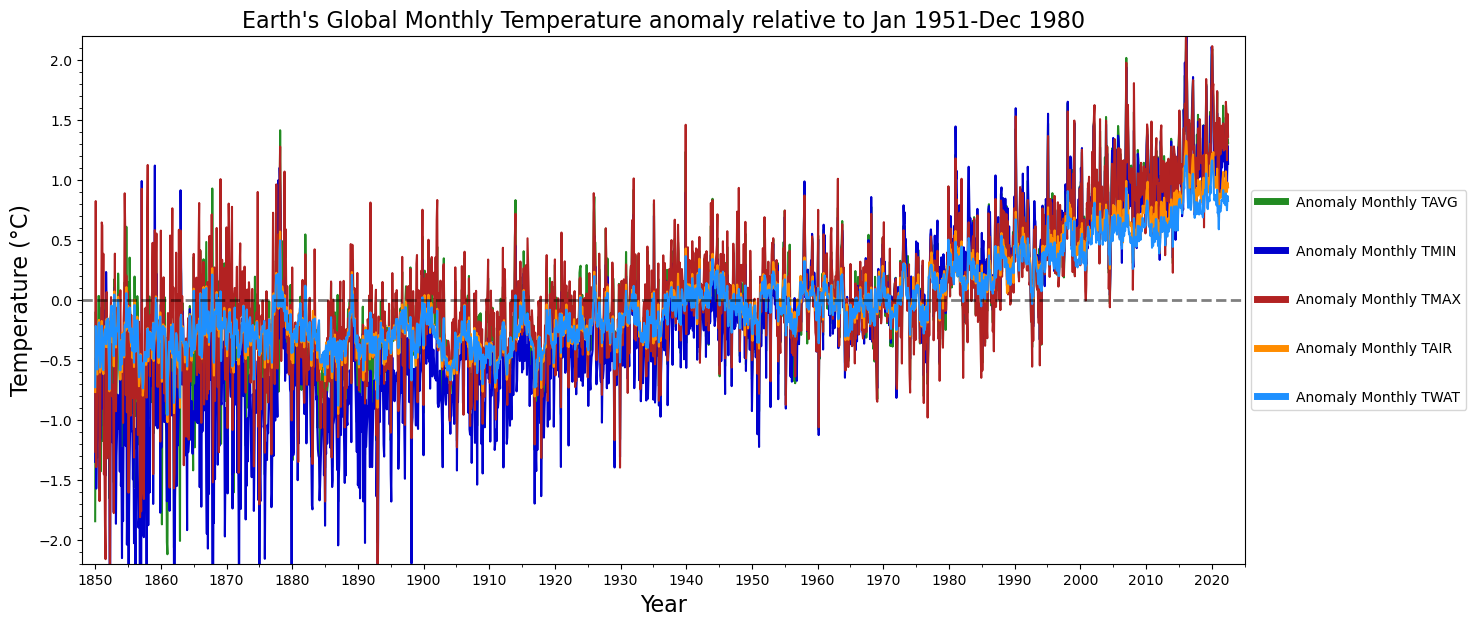

In [13]:
figure, ax = plt.subplots(1, figsize=(15,6))
ax.plot(global_temperature_data['Anomaly Monthly TAVG'], label='Anomaly Monthly TAVG', color = color_TAVG)
ax.plot(global_temperature_data['Anomaly Monthly TMIN'], label='Anomaly Monthly TMIN', color = color_TMIN)
ax.plot(global_temperature_data['Anomaly Monthly TMAX'], label='Anomaly Monthly TMAX', color = color_TMAX)
ax.plot(global_temperature_data['Anomaly Monthly TAIR'], label='Anomaly Monthly TAIR', color = color_TAIR)
ax.plot(global_temperature_data['Anomaly Monthly TWAT'], label='Anomaly Monthly TWAT', color = color_TWAT)
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),labelspacing=2.5)
for line in legend.get_lines(): # change the line width for the legend
    line.set_linewidth(5)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Temperature (°C)', fontsize=16)
ax.set_title('Earth\'s Global Monthly Temperature anomaly relative to Jan 1951-Dec 1980', fontsize=16)
ax.minorticks_on()
ax.set_xlim([dt.datetime.strptime('1848-01-01', '%Y-%d-%m').date(), dt.datetime.strptime('2025-01-01', '%Y-%d-%m').date()])
ax.set_ylim([-2.2,2.2])
ax.axhline(y = 0, color = 'k', linestyle = '--', linewidth=2, alpha = 0.5)
ax.xaxis.set_major_locator(mdates.YearLocator(10,month=1,day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(5,month=1,day=1))
plt.gcf().autofmt_xdate(bottom=0.0, rotation=0, ha='center')
save_fig('Eath\'s Temperature Monthly Anomalies')
plt.show()

The temperature evolution between 1850 and 2022 can be devided into two stages. 
1. Period 1850-1910: Temperature annomaly is onstant and oscilates around -0.5°C
2. Period 1910-2022: Steady and constant inscrease in the temperature anomaly starting at -0.5°C in 1910 and reaching 1.5°C in 2022. 
The second period is characterized by and aproximatively 2°C increase in temperatures in the last century, which is a very big change in such a small time period

As the next step we'd like to explore the yearly seasonality of the diffrenet datasets as it could further indicate us some trends that require a deaper investigation

Saving figure:" Seasonality of Monthly Anomaly Temperature "


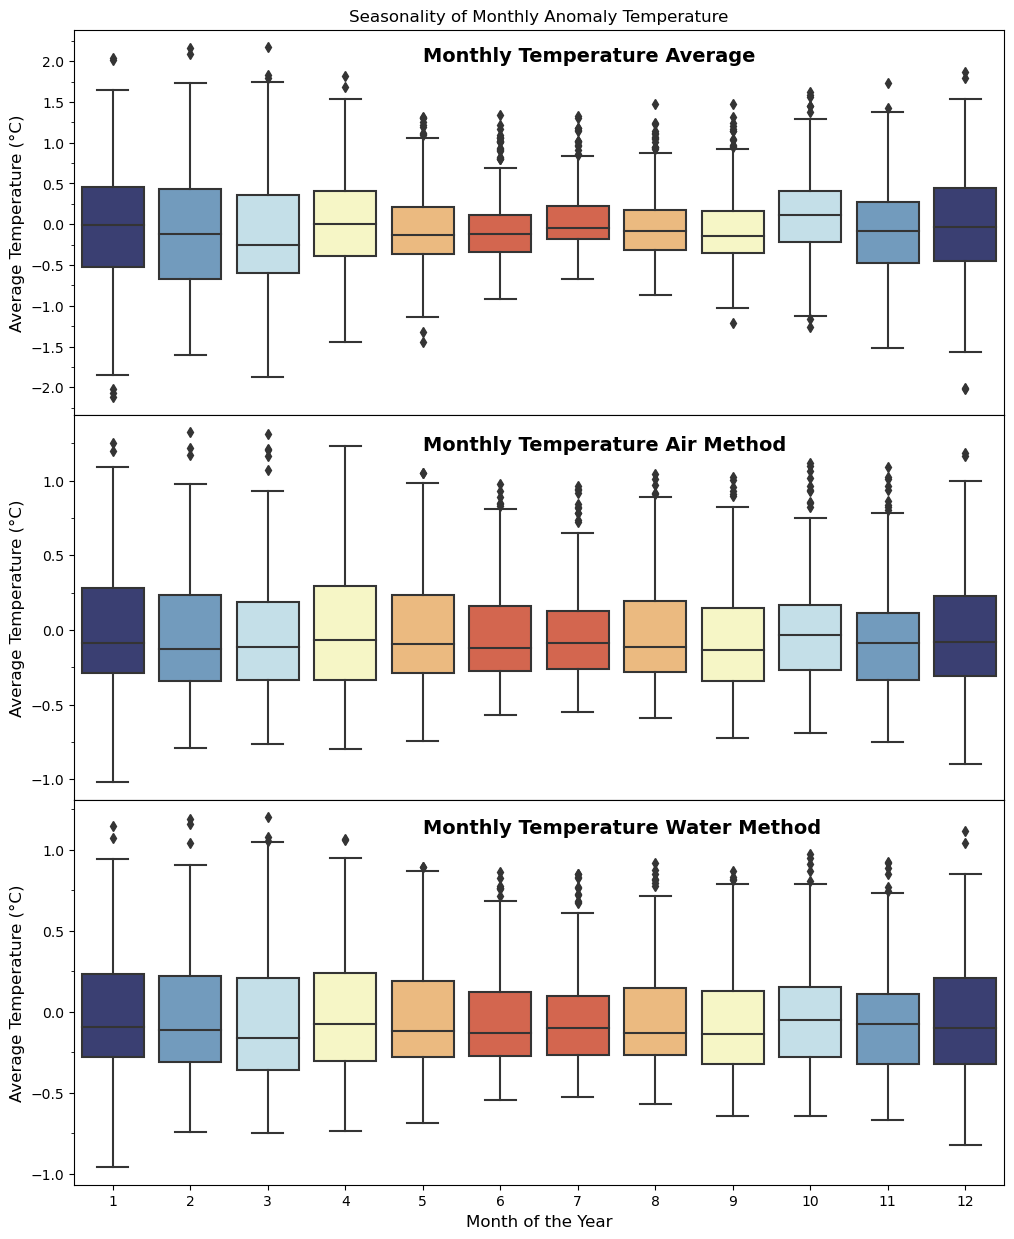

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 15))

fig.subplots_adjust(hspace=0)

sns.boxplot(data=global_temperature_data, x=global_temperature_data.index.month, y='Anomaly Monthly TAVG', palette=sns.color_palette(palette, 12), ax=ax1)
ax1.set_ylabel('Average Temperature (°C)', fontsize=12)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax1.text(x=4, y = 2, s = 'Monthly Temperature Average', fontsize=14, fontweight='bold')
ax1.set_title('Seasonality of Monthly Anomaly Temperature')

sns.boxplot(data=global_temperature_data, x=global_temperature_data.index.month, y='Anomaly Monthly TAIR', palette=sns.color_palette(palette, 12), ax=ax2)
ax2.set_ylabel('Average Temperature (°C)', fontsize=12)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax2.text(x=4, y = 1.2, s = 'Monthly Temperature Air Method', fontsize=14, fontweight='bold')

sns.boxplot(data=global_temperature_data, x=global_temperature_data.index.month, y='Anomaly Monthly TWAT', palette=sns.color_palette(palette, 12), ax=ax3)
ax3.set_xlabel('Month of the Year', fontsize=12)
ax3.set_ylabel('Average Temperature (°C)', fontsize=12)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax3.text(x=4, y = 1.1, s = 'Monthly Temperature Water Method', fontsize=14, fontweight='bold')

save_fig('Seasonality of Monthly Anomaly Temperature')
plt.show()

On the figure above we plot the average monthly temperature anomaly as a box-plot using the SeaBorn Python visualization package. Each box represents the statistical distribution of all temperature for a given month (e.g. 1 = Jan, 12 = Dec). The Color of the box represents the month's seasonm with blue colors standing for winter months and light orange colors for summer months (Mai-August).

#### General temperature trends: comparing all datasets
We have at our disposal several datasets representing earth's global temperature annomalies i.e. the minimum tempe

Saving figure:" Global Temperature Annual Anomaly 1 "


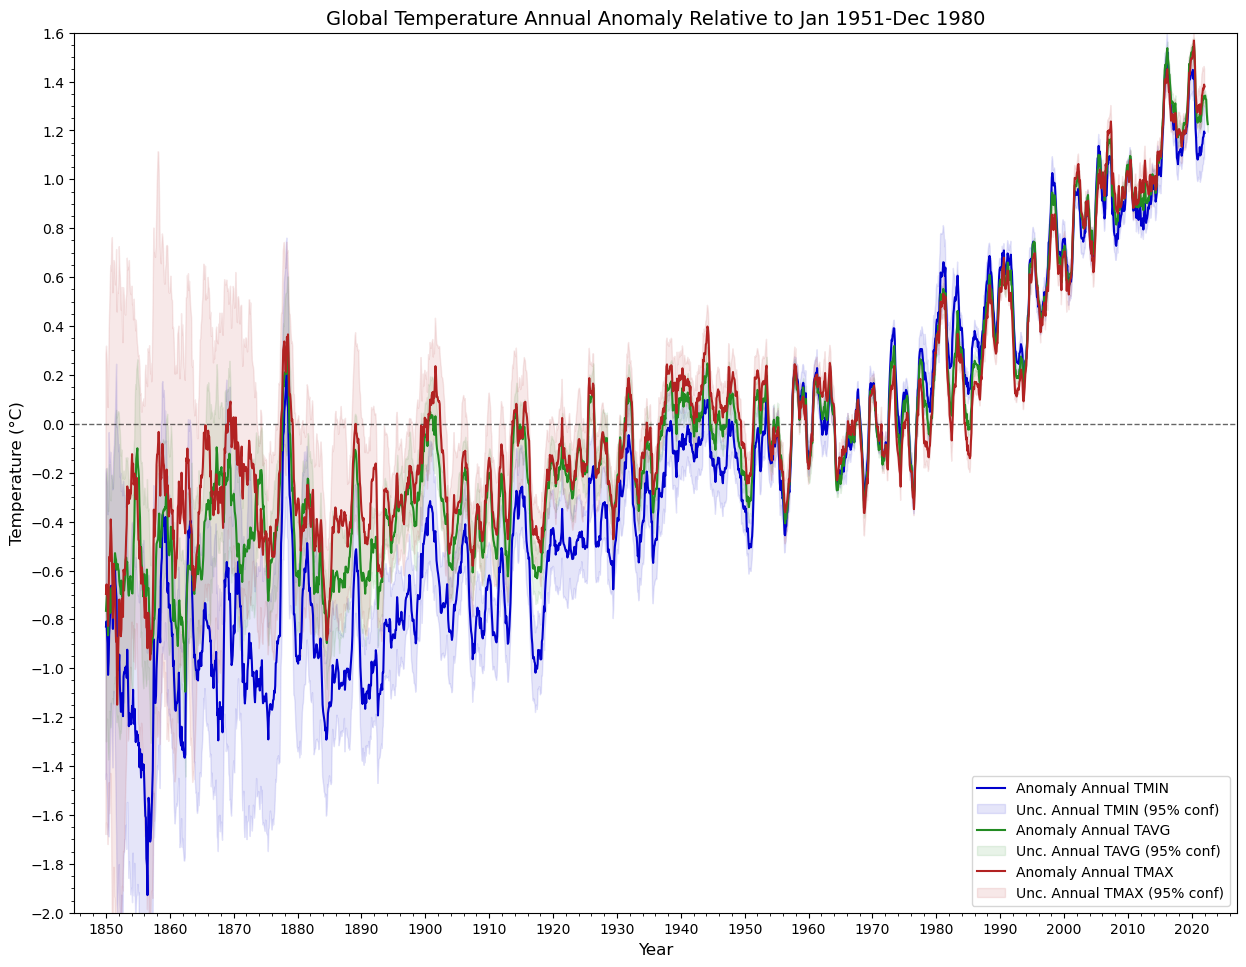

In [66]:
fig, (ax1) = plt.subplots(1, sharex=True, figsize=(15, 10))

fig.subplots_adjust(hspace=0)

ax1.plot(global_temperature_data['Anomaly Annual TMIN'],color=color_TMIN, label='Anomaly Annual TMIN')
ax1.fill_between(x = global_temperature_data['Anomaly Annual TMIN'].index, y1 = global_temperature_data['Anomaly Annual TMIN']-global_temperature_data['Unc. Annual TMIN'], y2 = global_temperature_data['Anomaly Annual TMIN'] + global_temperature_data['Unc. Annual TMIN'], alpha=0.1, edgecolor=color_TMIN, facecolor=color_TMIN,label='Unc. Annual TMIN (95% conf)')

ax1.plot(global_temperature_data['Anomaly Annual TAVG'], color=color_TAVG, label='Anomaly Annual TAVG')
ax1.fill_between(x = global_temperature_data['Anomaly Annual TAVG'].index, y1 = global_temperature_data['Anomaly Annual TAVG']-global_temperature_data['Unc. Annual TAVG'], y2 = global_temperature_data['Anomaly Annual TAVG'] + global_temperature_data['Unc. Annual TAVG'], alpha=0.1, edgecolor=color_TAVG, facecolor=color_TAVG,label='Unc. Annual TAVG (95% conf)')

ax1.plot(global_temperature_data['Anomaly Annual TMAX'], color=color_TMAX, label='Anomaly Annual TMAX')
ax1.fill_between(x = global_temperature_data['Anomaly Annual TMAX'].index, y1 = global_temperature_data['Anomaly Annual TMAX']-global_temperature_data['Unc. Annual TMAX'], y2 = global_temperature_data['Anomaly Annual TMAX'] + global_temperature_data['Unc. Annual TMAX'], alpha=0.1, edgecolor=color_TMAX, facecolor=color_TMAX,label='Unc. Annual TMAX (95% conf)')
ax1.axhline(y = 0, color = 'k', linestyle= '--', linewidth = 1, alpha = 0.5, zorder = 1)
ax1.legend(loc='lower right')
ax1.set_ylabel('Temperature (°C)', fontsize=11)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.set_xlim([dt.datetime.strptime('1845-01-01', '%Y-%d-%m').date(), dt.datetime.strptime('2027-01-01', '%Y-%d-%m').date()])
ax1.set_title('Global Temperature Annual Anomaly Relative to Jan 1951-Dec 1980',fontsize=14)
ax1.set_xlabel('Year',fontsize=12)
ax1.set_ylabel('Temperature (°C)',fontsize=12)
ax1.minorticks_on()
ax1.set_ylim([-2,1.6])
ax1.xaxis.set_major_locator(mdates.YearLocator(10,month=1,day=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.YearLocator(2,month=1,day=1))
plt.gcf().autofmt_xdate(bottom=0.0, rotation=0, ha='center')
save_fig('Global Temperature Annual Anomaly 1')
plt.show()

Saving figure:" Global Temperature Annual Anomaly 2 "


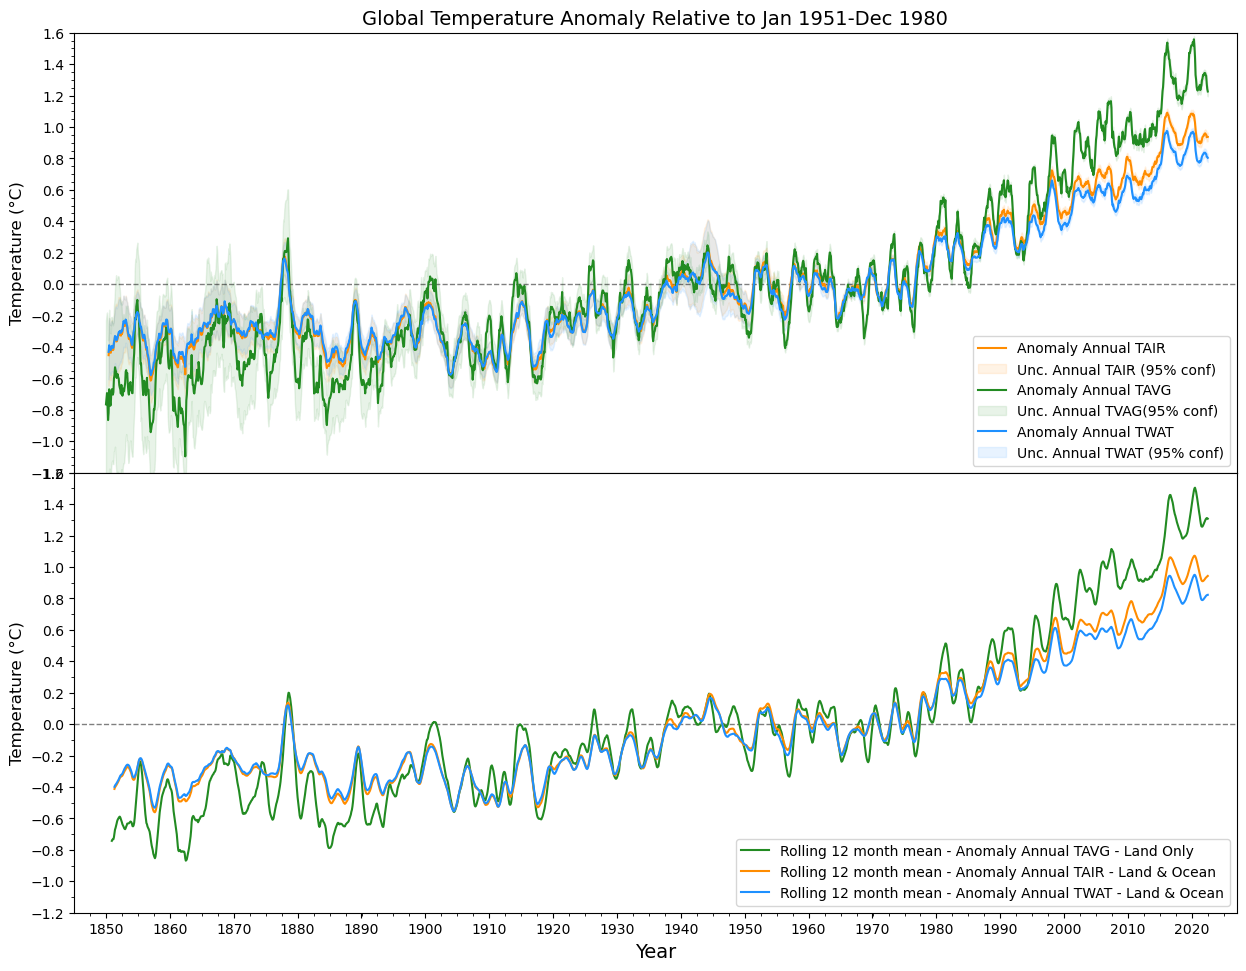

In [88]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

fig.subplots_adjust(hspace=0)

ax1.plot(global_temperature_data['Anomaly Annual TAIR'], color=color_TAIR, label='Anomaly Annual TAIR')
ax1.fill_between(x = global_temperature_data['Anomaly Annual TAIR'].index, y1 = global_temperature_data['Anomaly Annual TAIR']-global_temperature_data['Unc. Annual TAIR'], y2 = global_temperature_data['Anomaly Annual TAIR'] + global_temperature_data['Unc. Annual TAIR'], alpha=0.1, edgecolor=color_TAIR, facecolor=color_TAIR,label='Unc. Annual TAIR (95% conf)')

ax1.plot(global_temperature_data['Anomaly Annual TAVG'], color=color_TAVG, label='Anomaly Annual TAVG')
ax1.fill_between(x = global_temperature_data['Anomaly Annual TAVG'].index, y1 = global_temperature_data['Anomaly Annual TAVG']-global_temperature_data['Unc. Annual TAVG'], y2 = global_temperature_data['Anomaly Annual TAVG'] + global_temperature_data['Unc. Annual TAVG'], alpha=0.1, edgecolor=color_TAVG, facecolor=color_TAVG,label='Unc. Annual TVAG(95% conf)')

ax1.plot(global_temperature_data['Anomaly Annual TWAT'], color=color_TWAT, label='Anomaly Annual TWAT')
ax1.fill_between(x = global_temperature_data['Anomaly Annual TWAT'].index, y1 = global_temperature_data['Anomaly Annual TWAT']-global_temperature_data['Unc. Annual TWAT'], y2 = global_temperature_data['Anomaly Annual TWAT'] + global_temperature_data['Unc. Annual TWAT'], alpha=0.1, edgecolor=color_TWAT, facecolor=color_TWAT,label='Unc. Annual TWAT (95% conf)')
ax1.axhline(y = 0, color = 'k', linestyle= '--', linewidth = 1, alpha = 0.5, zorder = 1)
ax1.legend(loc='lower right')
ax1.set_ylabel('Temperature (°C)', fontsize=11)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.set_xlim([dt.datetime.strptime('1845-01-01', '%Y-%d-%m').date(), dt.datetime.strptime('2027-01-01', '%Y-%d-%m').date()])
ax1.set_title('Global Temperature Anomaly Relative to Jan 1951-Dec 1980',fontsize=14)
ax1.set_ylabel('Temperature (°C)',fontsize=12)
ax1.set_ylim([-1.2,1.6])
ax1.minorticks_on()
ax1.xaxis.set_major_locator(mdates.YearLocator(10,month=1,day=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.YearLocator(2,month=1,day=1))

ax2.plot(global_temperature_data['Anomaly Annual TAVG'].rolling(12).mean(), color=color_TAVG, label='Rolling 12 month mean - Anomaly Annual TAVG - Land Only')
ax2.plot(global_temperature_data['Anomaly Annual TAIR'].rolling(12).mean(), color=color_TAIR, label='Rolling 12 month mean - Anomaly Annual TAIR - Land & Ocean')
ax2.plot(global_temperature_data['Anomaly Annual TWAT'].rolling(12).mean(), color=color_TWAT, label='Rolling 12 month mean - Anomaly Annual TWAT - Land & Ocean')
ax2.legend(loc='lower right')
ax2.set_xlabel('Year',fontsize=14)
ax2.set_ylabel('Temperature (°C)',fontsize=12)
ax2.axhline(y = 0, color = 'k', linestyle= '--', linewidth = 1, alpha = 0.5, zorder = 1)
ax2.set_ylim([-1.2,1.6])
ax2.minorticks_on()
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

plt.gcf().autofmt_xdate(bottom=0.0, rotation=0, ha='center')
save_fig('Global Temperature Annual Anomaly 2')
plt.show()

Both datasets "Land only" and "Land & Ocean" follow the same trend, namely a temperature increase from the beginning of the 20th century. Yet, the Land only (green) curve is following a slightly higher temperature increase in the last 50 years of measurements.  This difference in temperature increases is between the two categories of datasets most probably originates from complex physical phenomenas on the global scale.

## Seasonal Autoregressive Integrated Moving Average (SARIMA)
We would like to use a statistical analysis model (SARIMA) on our temperature time series data to either better understand the data set or to predict future trends

An ARIMA model can be understood by outlining each of its components as follows:
* Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
* Integrated (I): represents the differencing of raw observations to allow the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
* Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.
* Hyperparameters of SARIMA model:
    - p (Auto-Regressive Order): the number of lagged value terms we used in the standard auto-regressive component of our model
    - d (Order of Differencing): the number of times we applied standard differencing to our before modeling
    - q (Moving-Average Order): the number of past error terms we used in the standard moving-average component of our model
    - P, D, and Q are then the seasonal counterparts of p, d, and q. Simply the number of seasonal terms or seasonal differencings we apply to our data
    - S (Seasonal Period): the length of the seasonal cycle based on the number of data points.

Now we split the datasets into a train and test subsets, so that we can train the SARIMA model on the train part and test the model's performance on the test subset. 

In [17]:
tss = TimeSeriesSplit(n_splits = 2, test_size = 331) # test data 1995 - 2022

X = global_temperature_data
# y = global_temperature_data.index

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    # y_train, y_test = y[train_index], y[test_index]

In [87]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TAVG_train.pkl'):
    pass
else:
    SARIMA_model_TAVG_train = pm.auto_arima(X_train['Anomaly Annual TAVG'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TAVG_train, MODELS_PATH + '/' + 'SARIMA_model_TAVG_train.pkl')

In [21]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TAIR_train.pkl'):
    pass
else:
    SARIMA_model_TAIR_train = pm.auto_arima(X_train['Anomaly Annual TAIR'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TAIR_train, MODELS_PATH + '/' + 'SARIMA_model_TAIR_train.pkl')

In [22]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TWAT_train.pkl'):
    pass
else:
    SARIMA_model_TWAT_train = pm.auto_arima(X_train['Anomaly Annual TWAT'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TWAT_train, MODELS_PATH + '/' + 'SARIMA_model_TWAT_train.pkl')

In [24]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TMIN_train.pkl'):
    pass
else:
    SARIMA_model_TMIN_train = pm.auto_arima(X_train['Anomaly Annual TMIN'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TMIN_train, MODELS_PATH + '/' + 'SARIMA_model_TMIN_train.pkl')

In [25]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TMAX_train.pkl'):
    pass
else:
    SARIMA_model_TMAX_train = pm.auto_arima(X_train['Anomaly Annual TMAX'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TMAX_train, MODELS_PATH + '/' + 'SARIMA_model_TMAX_train.pkl')

Saving figure:" Global Temperature Forecast Benchmark "


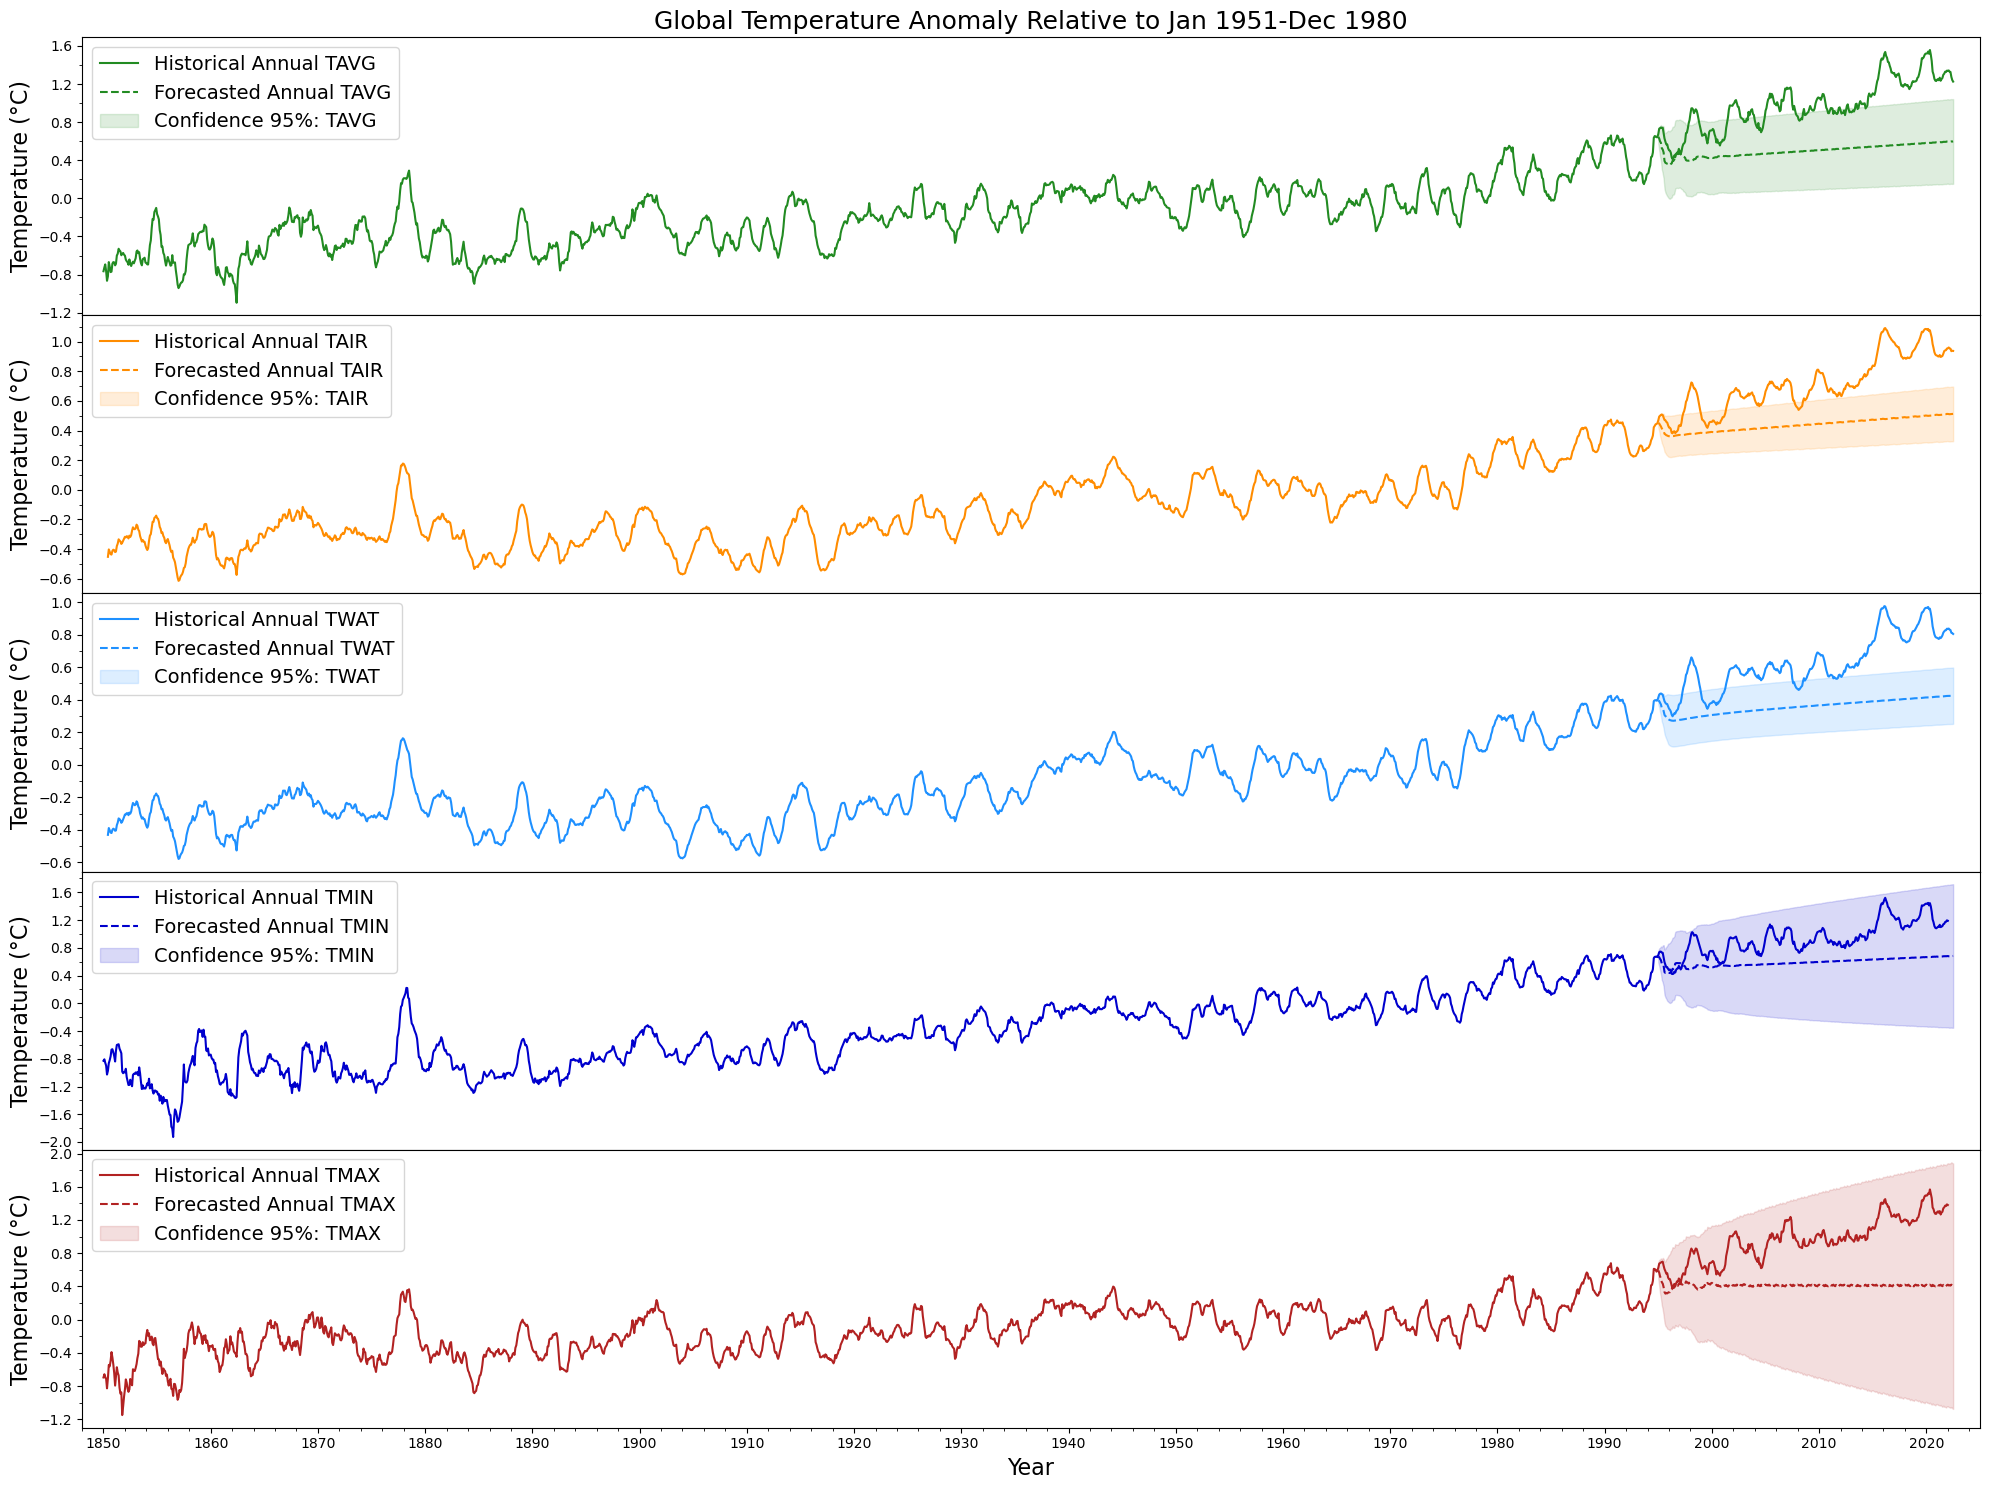

In [26]:
forecast_periods_train = X_test['Anomaly Annual TAVG'].size

fitted_TAVG, confint_TAVG = joblib.load(MODELS_PATH + '/' + 'SARIMA_model_TAVG_train.pkl').predict(n_periods = forecast_periods_train, return_conf_int = True, alpha=0.05)
fitted_TAIR, confint_TAIR = joblib.load(MODELS_PATH + '/' + 'SARIMA_model_TAIR_train.pkl').predict(n_periods = forecast_periods_train, return_conf_int = True, alpha=0.05)
fitted_TWAT, confint_TWAT = joblib.load(MODELS_PATH + '/' + 'SARIMA_model_TWAT_train.pkl').predict(n_periods = forecast_periods_train, return_conf_int = True, alpha=0.05)
fitted_TMIN, confint_TMIN = joblib.load(MODELS_PATH + '/' + 'SARIMA_model_TMIN_train.pkl').predict(n_periods = forecast_periods_train, return_conf_int = True, alpha=0.05)
fitted_TMAX, confint_TMAX = joblib.load(MODELS_PATH + '/' + 'SARIMA_model_TMAX_train.pkl').predict(n_periods = forecast_periods_train, return_conf_int = True, alpha=0.05)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20, 15))

ax1.plot(global_temperature_data['Anomaly Annual TAVG'], color=color_TAVG, label='Historical Annual TAVG', zorder = 3)
ax1.plot(fitted_TAVG.index, fitted_TAVG, color=color_TAVG, linestyle='dashed', label='Forecasted Annual TAVG', zorder = 2)
ax1.fill_between(fitted_TAVG.index, confint_TAVG[:, 0], confint_TAVG[:, 1], color=color_TAVG, alpha=.15, label='Confidence 95%: TAVG', zorder = 1)

ax2.plot(global_temperature_data['Anomaly Annual TAIR'], color=color_TAIR, label='Historical Annual TAIR', zorder = 6)
ax2.plot(fitted_TAIR.index, fitted_TAIR, color=color_TAIR, linestyle='dashed', label='Forecasted Annual TAIR', zorder = 5)
ax2.fill_between(fitted_TAIR.index, confint_TAIR[:, 0], confint_TAIR[:, 1], color=color_TAIR, alpha=.15, label='Confidence 95%: TAIR', zorder = 4)

ax3.plot(global_temperature_data['Anomaly Annual TWAT'], color=color_TWAT, label='Historical Annual TWAT', zorder = 9)
ax3.plot(fitted_TWAT.index, fitted_TWAT, color=color_TWAT, linestyle='dashed', label='Forecasted Annual TWAT', zorder = 8)
ax3.fill_between(fitted_TWAT.index, confint_TWAT[:, 0], confint_TWAT[:, 1], color=color_TWAT, alpha=.15, label='Confidence 95%: TWAT', zorder = 7)

ax4.plot(global_temperature_data['Anomaly Annual TMIN'], color=color_TMIN, label='Historical Annual TMIN', zorder = 11)
ax4.plot(fitted_TMIN.index, fitted_TMIN, color=color_TMIN, linestyle='dashed', label='Forecasted Annual TMIN', zorder = 12)
ax4.fill_between(fitted_TMIN.index, confint_TMIN[:, 0], confint_TMIN[:, 1], color=color_TMIN, alpha=.15, label='Confidence 95%: TMIN', zorder = 10)

ax5.plot(global_temperature_data['Anomaly Annual TMAX'], color=color_TMAX, label='Historical Annual TMAX', zorder = 14)
ax5.plot(fitted_TMAX.index, fitted_TMAX, color=color_TMAX, linestyle='dashed', label='Forecasted Annual TMAX', zorder = 15)
ax5.fill_between(fitted_TMAX.index, confint_TMAX[:, 0], confint_TMAX[:, 1], color=color_TMAX, alpha=.15, label='Confidence 95%: TMAX', zorder = 13)

ax1.set_title("Global Temperature Anomaly Relative to Jan 1951-Dec 1980", fontsize=18)
ax1.set_ylabel('Temperature (°C)', fontsize="16")
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax1.legend(loc='upper left', fontsize="14")

ax2.set_ylabel('Temperature (°C)', fontsize="16")
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.legend(loc='upper left', fontsize="14")

ax3.set_ylabel('Temperature (°C)', fontsize="16")
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax3.legend(loc='upper left', fontsize="14")

ax4.set_ylabel('Temperature (°C)', fontsize="16")
ax4.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax4.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax4.legend(loc='upper left', fontsize="14")

ax5.set_ylabel('Temperature (°C)', fontsize="16")
ax5.set_xlabel('Year', fontsize="16")
ax5.minorticks_on()
ax5.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax5.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax5.legend(loc='upper left', fontsize="14")

ax5.set_xlim([dt.datetime.strptime('1848-01-01', '%Y-%d-%m').date(), dt.datetime.strptime('2025-01-01', '%Y-%d-%m').date()])
ax5.xaxis.set_major_locator(mdates.YearLocator(10,month=1,day=1))
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax5.xaxis.set_minor_locator(mdates.YearLocator(2,month=1,day=1))
plt.gcf().autofmt_xdate(bottom=0.0, rotation=0, ha='center')
plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)
save_fig('Global Temperature Forecast Benchmark')
plt.show()

In [28]:
def time_sereis_forecast_accuracy(test_data, forecast_data):
    MSE_value = mean_squared_error(test_data, forecast_data)
    RMSE_value = mean_squared_error(test_data, forecast_data, squared=False)
    MAE_value = mean_absolute_error(test_data, forecast_data)
    MAPE_value = mean_absolute_percentage_error(test_data, forecast_data)
    return dict(MSE = MSE_value, RMSE = RMSE_value, MAE = MAE_value, MAPE = MAPE_value) 


all_ts_forecast_accuracies = dict()
all_ts_forecast_accuracies.update({'Anomaly Annual TAVG' : time_sereis_forecast_accuracy(X_test['Anomaly Annual TAVG'], fitted_TAVG[:len(X_test.index)])})
all_ts_forecast_accuracies.update({'Anomaly Annual TAIR' : time_sereis_forecast_accuracy(X_test['Anomaly Annual TAIR'], fitted_TAIR[:len(X_test.index)])})
all_ts_forecast_accuracies.update({'Anomaly Annual TWAT' : time_sereis_forecast_accuracy(X_test['Anomaly Annual TWAT'], fitted_TWAT[:len(X_test.index)])})
all_ts_forecast_accuracies.update({'Anomaly Annual TMIN' : time_sereis_forecast_accuracy(X_test['Anomaly Annual TMIN'].dropna(), fitted_TMIN[:len(X_test['Anomaly Annual TMIN'].dropna())].dropna())})
all_ts_forecast_accuracies.update({'Anomaly Annual TMAX' : time_sereis_forecast_accuracy(X_test['Anomaly Annual TMAX'].dropna(), fitted_TMAX[:len(X_test['Anomaly Annual TMAX'].dropna())].dropna())})
all_ts_forecast_accuracies

{'Anomaly Annual TAVG': {'MSE': 0.2762726660489493,
  'RMSE': 0.5256164628785416,
  'MAE': 0.47782965027781943,
  'MAPE': 0.4594205673843147},
 'Anomaly Annual TAIR': {'MSE': 0.09962992114464027,
  'RMSE': 0.3156420775889049,
  'MAE': 0.2775586579918637,
  'MAPE': 0.35784075703370305},
 'Anomaly Annual TWAT': {'MSE': 0.08968991116179549,
  'RMSE': 0.29948273933867287,
  'MAE': 0.2672885181218897,
  'MAPE': 0.40002754936574153},
 'Anomaly Annual TMIN': {'MSE': 0.1592080786352668,
  'RMSE': 0.3990088703716583,
  'MAE': 0.34964147685353264,
  'MAPE': 0.34581861028639505},
 'Anomaly Annual TMAX': {'MSE': 0.3757480091300692,
  'RMSE': 0.6129828783335382,
  'MAE': 0.5528126901633523,
  'MAPE': 0.5338939708779369}}

Saving figure:" Time Series Forecast Accuracy Metrics "


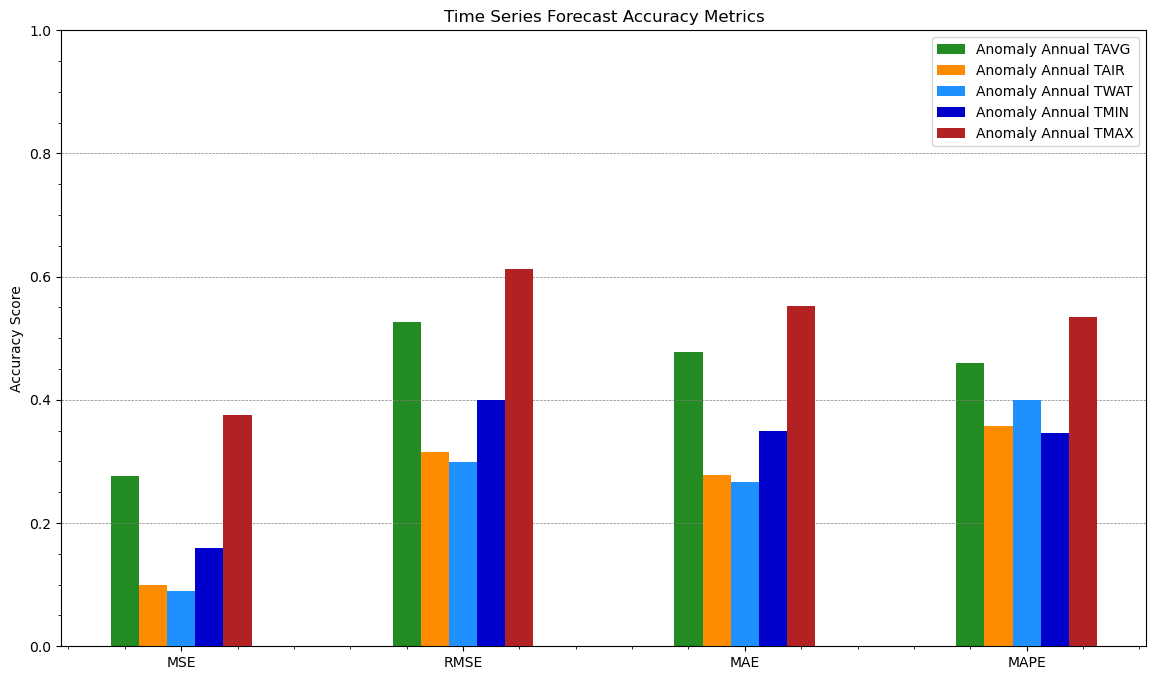

In [29]:
X_axis_labels = list(all_ts_forecast_accuracies['Anomaly Annual TAVG'].keys())

accuracy_data_TAVG = list(all_ts_forecast_accuracies['Anomaly Annual TAVG'].values())
accuracy_data_TAIR = list(all_ts_forecast_accuracies['Anomaly Annual TAIR'].values())
accuracy_data_TWAT = list(all_ts_forecast_accuracies['Anomaly Annual TWAT'].values())
accuracy_data_TMIN = list(all_ts_forecast_accuracies['Anomaly Annual TMIN'].values())
accuracy_data_TMAX = list(all_ts_forecast_accuracies['Anomaly Annual TMAX'].values())

X_axis = np.arange(len(X_axis_labels))
width = 0.1

plt.figure(figsize=(14,8))
plt.bar(X_axis, accuracy_data_TAVG, width, label = 'Anomaly Annual TAVG', color=color_TAVG, zorder=1)
plt.bar(X_axis + width, accuracy_data_TAIR, width, label = 'Anomaly Annual TAIR', color=color_TAIR, zorder=2)
plt.bar(X_axis + width*2, accuracy_data_TWAT, width, label = 'Anomaly Annual TWAT', color=color_TWAT, zorder=3)
plt.bar(X_axis + width*3, accuracy_data_TMIN, width, label = 'Anomaly Annual TMIN', color=color_TMIN, zorder=4)
plt.bar(X_axis + width*4, accuracy_data_TMAX, width, label = 'Anomaly Annual TMAX', color=color_TMAX, zorder=5)
plt.xticks(X_axis, X_axis_labels)
plt.ylabel("Prediction Score (different units)")
plt.title("Time Series Forecast Accuracy Metrics")
plt.xticks(X_axis+width*2,X_axis_labels)
plt.minorticks_on()
plt.ylim([0,1])
plt.grid(axis='y',color='gray', linestyle='dashed', linewidth=0.5, zorder=1)
plt.legend()
save_fig('Time Series Forecast Accuracy Metrics')
plt.show()

- **MSE**: mean square error corresponds to the mean value of errors between predicted data and the real data. The unit is the same as the data, hence, temperature in degrees Celcius. Isn't paramount for our purposes.
- **RMSE**: root mean square error corresponds to the root mean value of the errors between predicted data and real data. Good parameter to compare the performance of different models on a single dataset, rather than comparing different datasets. Isn't paramount for our purposes. less are the penalized errors, better is the model.
- **MAE**: mean absolute error corresponds to the measure of errors between paired observations expressing the same phenomenon. Sum of absolute errors divided by the sample size. Uses the same scale as the data being measured. The lower, less are the errors, better is the model.
- **MAPE**: mean absolute percentage error is a measure of prediction accuracy of a forecasting method in statistics. The lower, less are the errors, better is the model. Is expressed in pourcetange units, hence, on the figure above numbers have to be multiplied by 100 to convert the result in percents. In our case most of the MAPE values range between 37-50%, hence, our SARIMA forecasting is reasonable. 

Interpreting forecast results. Forecasting all 5 datasets isn't great and the errors are quite substantion. We can't qualify neither of our SARIMA models to be accurate (difference with precise). 
But, we see that the uncertainty (+/- 1 standard deviation) match the test data. In other words, the real historical "test" data falls on top of the SARIMA's model prediction within the confidence range 95% (how much sigmas). The figure above is the term accuracy the right one ? 
Nevertheless, we are able to extract the general trend of this forecast with a quite large area of confidence range.
We would like to explore forecasting time series using neural networks, and compare the result to the statistical SARIMA model forecasting method. 

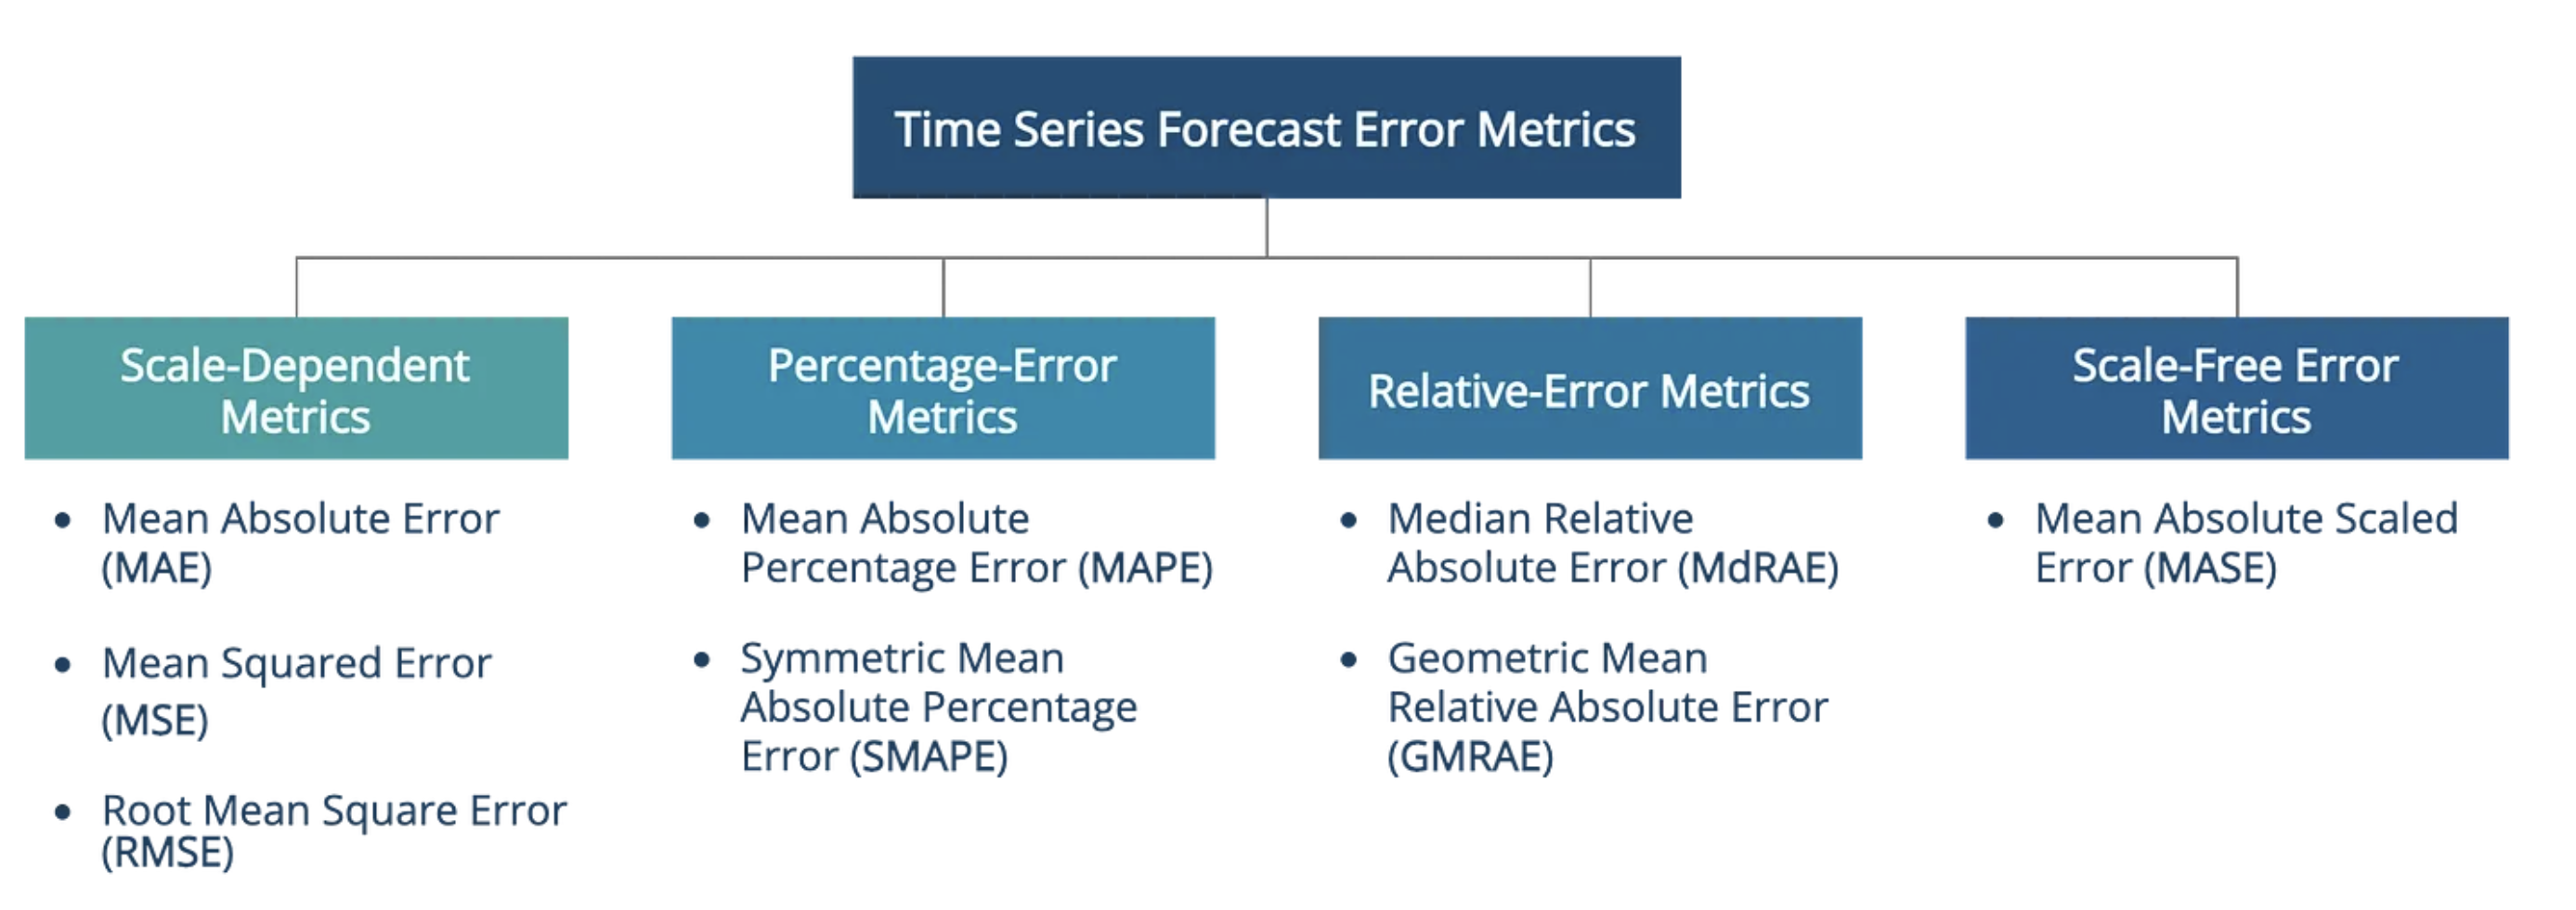

In [30]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TWAT_Full_Data.pkl'):
    pass
else:
    SARIMA_model_TWAT_Full_Data = pm.auto_arima(global_temperature_data['Anomaly Annual TWAT'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TWAT_Full_Data, MODELS_PATH + '/' + 'SARIMA_model_TWAT_Full_Data.pkl')

In [31]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TAIR_Full_Data.pkl'):
    pass
else:
    SARIMA_model_TAIR_Full_Data = pm.auto_arima(global_temperature_data['Anomaly Annual TAIR'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TAIR_Full_Data, MODELS_PATH + '/' + 'SARIMA_model_TAIR_Full_Data.pkl')

In [32]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TAVG_Full_Data.pkl'):
    pass
else:
    SARIMA_model_TAVG_Full_Data = pm.auto_arima(global_temperature_data['Anomaly Annual TAVG'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TAVG_Full_Data, MODELS_PATH + '/' + 'SARIMA_model_TAVG_Full_Data.pkl')

In [33]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TMIN_Full_Data.pkl'):
    pass
else:
    SARIMA_model_TMIN_Full_Data = pm.auto_arima(global_temperature_data['Anomaly Annual TMIN'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    
    joblib.dump(SARIMA_model_TMIN_Full_Data, MODELS_PATH + '/' + 'SARIMA_model_TMIN_Full_Data.pkl')

In [34]:
if os.path.isfile(MODELS_PATH + '/' + 'SARIMA_model_TMAX_Full_Data.pkl'):
    pass
else:
    SARIMA_model_TMAX_Full_Data = pm.auto_arima(global_temperature_data['Anomaly Annual TMAX'].dropna(),
    start_p=2, start_q=2,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=True, #set to seasonal
    m=12, #12 is the frequncy of the cycle
    start_P=0,
    d=None,
    trace=True,
    D=1, #order of the seasonal differencing
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)

    joblib.dump(SARIMA_model_TMAX_Full_Data, MODELS_PATH + '/' + 'SARIMA_model_TMAX_Full_Data.pkl')

Saving figure:" Temperature Anomaly Forecast in 2100 "


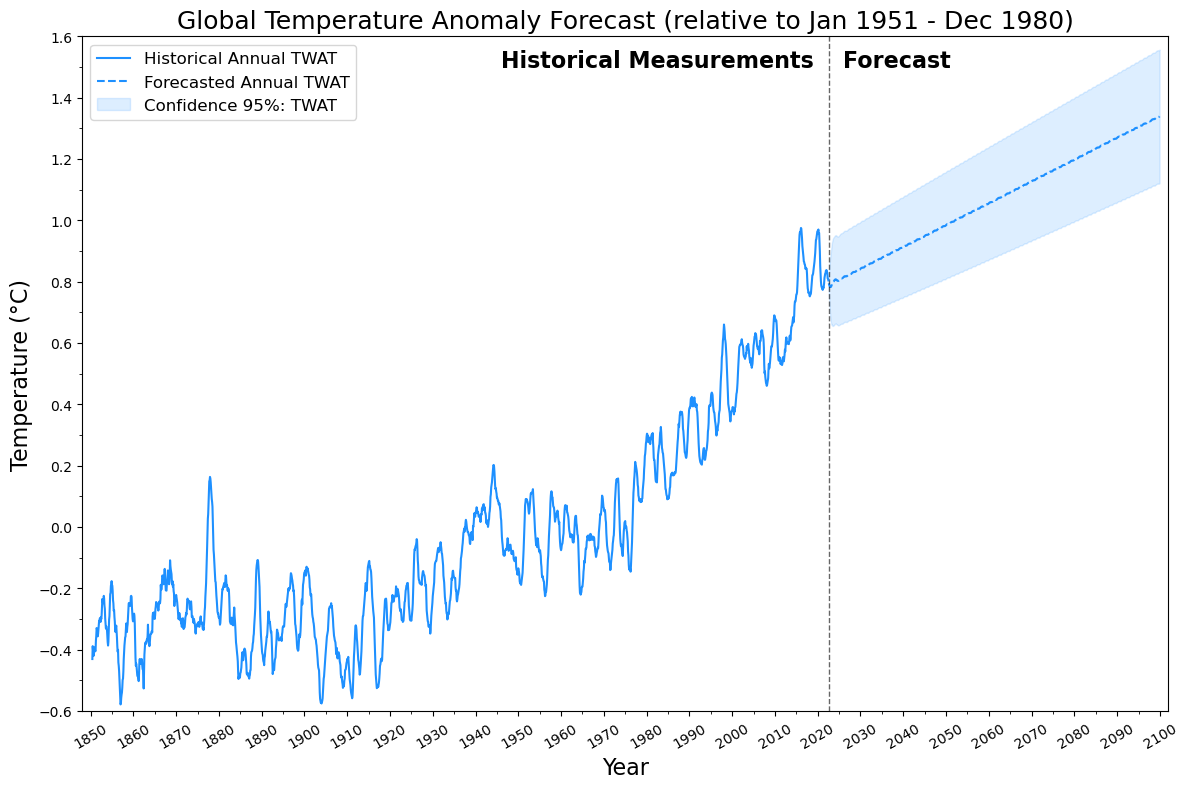

In [56]:
forecast_periods_21_century = int((2099 - global_temperature_data['Anomaly Annual TWAT'].index.year[-1])*12  + (12 - global_temperature_data['Anomaly Annual TWAT'].index.month[-1]))# Forecast for the entire 21th century

fitted_full_TWAT, confint_full_TWAT = joblib.load(MODELS_PATH + '/' + 'SARIMA_model_TWAT_Full_Data.pkl').predict(n_periods = forecast_periods_21_century, return_conf_int = True, alpha=0.05)

fig, (ax1) = plt.subplots(1, figsize=(12, 8))

ax1.plot(global_temperature_data['Anomaly Annual TWAT'], color=color_TWAT, label='Historical Annual TWAT', zorder = 3)
ax1.plot(fitted_full_TWAT.index, fitted_full_TWAT, color=color_TWAT, linestyle='dashed', label='Forecasted Annual TWAT', zorder = 2)
ax1.fill_between(fitted_full_TWAT.index, confint_full_TWAT[:, 0], confint_full_TWAT[:, 1], color=color_TWAT, alpha=.15, label='Confidence 95%: TWAT', zorder = 1)

ax1.set_title("Global Temperature Anomaly Forecast (relative to Jan 1951 - Dec 1980)", fontsize=18)

ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.legend(loc='upper left', fontsize=12)
ax1.set_ylabel('Temperature (°C)', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
ax1.axvline(x = fitted_full_TWAT.index[0], color = 'k', linestyle= '--', linewidth = 1, alpha = 0.6)
ax1.text(x=dt.datetime.strptime('1946-01-01', '%Y-%d-%m').date(), y=1.5, s = 'Historical Measurements',fontsize=16, weight='bold')
ax1.text(x=dt.datetime.strptime('2026-01-01', '%Y-%d-%m').date(), y=1.5, s = 'Forecast',fontsize=16, weight='bold')

# x=1848, y = 1.425, s = '(Data normalized by the average temperature of 1951-1980)',fontsize=8, style='italic')

# legend = ax1.legend(loc='upper left')
# for line in legend.get_lines():
#     line.set_linewidth(5)
    # line.set_fontsize(20)
# save_fig(saved_figure_label)
ax1.set_xlim([dt.datetime.strptime('1848-01-01', '%Y-%d-%m').date(), dt.datetime.strptime('2102-01-01', '%Y-%m-%d').date()])
ax1.set_ylim([-0.6, 1.6])

ax1.xaxis.set_major_locator(mdates.YearLocator(10,month=1,day=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.YearLocator(5,month=1,day=1))
plt.gcf().autofmt_xdate(bottom=0.0, rotation=30, ha='center')
plt.tight_layout()
save_fig('Temperature Anomaly Forecast in 2100')
plt.show()

In [108]:
def temperature_forecast_estimator(model_names, forecast_period):
    result = dict()
    for name in model_names:
        fitted, confint = joblib.load(MODELS_PATH + '/' + 'SARIMA_model_' + name + '_Full_Data.pkl').predict(n_periods = forecast_period, return_conf_int = True, alpha=0.05)
        result['value_' + name] = fitted[-1]
        result['error_' + name] = fitted[-1] - confint[-1,0]
    return result

In [109]:
model_names = ['TWAT', 'TAIR', 'TAVG', 'TMIN', 'TMAX']
temperature_anomaly_21_century = temperature_forecast_estimator(model_names, forecast_periods_21_century)
temperature_anomaly_21_century

{'value_TWAT': 1.3390501500148213,
 'error_TWAT': 0.2178259712161732,
 'value_TAIR': 1.3098864339530163,
 'error_TAIR': 0.25501375167868146,
 'value_TAVG': 2.0571851137039485,
 'error_TAVG': 0.5081094079723671,
 'value_TMIN': 1.738039018277248,
 'error_TMIN': 0.7396171872284532,
 'value_TMAX': 2.0215019635528066,
 'error_TMAX': 0.5979791463069835}

In [110]:
temperature_anomaly_21_century_values = [value for key, value in temperature_anomaly_21_century.items() if 'value' in key.lower()]
temperature_anomaly_21_century_errors = [value for key, value in temperature_anomaly_21_century.items() if 'error' in key.lower()]

Saving figure:" Temperature Anomaly Forecast in 2100 "


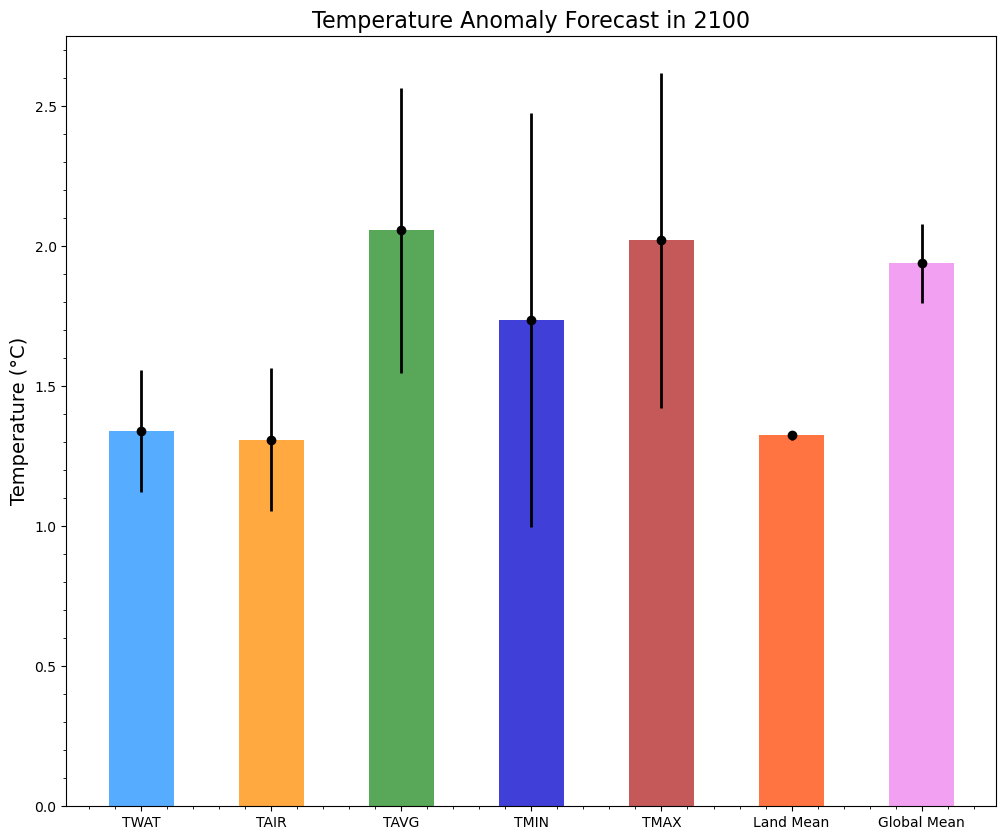

In [111]:
land_2100_temperautre_anomaly,land_2100_temperautre_anomaly_uncertainty = np.mean(temperature_anomaly_21_century_values[0:2]), np.std(temperature_anomaly_21_century_values[0:2])
global_2100_temperautre_anomaly, global_2100_temperautre_anomaly_uncertainty = np.mean(temperature_anomaly_21_century_values[2:]), np.std(temperature_anomaly_21_century_values[2:])
list_colors = [color_TWAT, color_TAIR, color_TAVG, color_TMIN, color_TMAX] + ['orangered', 'violet']

model_names = model_names + ['Land Mean', 'Global Mean']
temperature_anomaly_21_century_values = temperature_anomaly_21_century_values + [land_2100_temperautre_anomaly, global_2100_temperautre_anomaly]
temperature_anomaly_21_century_errors = temperature_anomaly_21_century_errors + [land_2100_temperautre_anomaly_uncertainty, global_2100_temperautre_anomaly_uncertainty]

fig , ax = plt.subplots(1, figsize=(12,10))
ax.bar(model_names, temperature_anomaly_21_century_values , color=list_colors, alpha = 0.75, width=0.5)
ax.errorbar(model_names, temperature_anomaly_21_century_values, yerr=temperature_anomaly_21_century_errors , elinewidth=2, fmt="o", color='k')
ax.set_ylabel('Temperature (°C)', fontsize=14)
ax.set_title('Temperature Anomaly Forecast in 2100', fontsize=16)
save_fig('Temperature Anomaly Forecast in 2100')
ax.minorticks_on()
plt.show()

We are able to predict that by the end of the 21th century the temoerature anomaly will continue rising and will reach a 1.32°C for the land only temperatures and 1.94°C for the global land and ocean earth's surface. Our prediction is in coherent agreement with the scientifically predicted values published in multiple scientific journals.